In [2]:
# Import the required modules
from IPython.display import clear_output
import PIL.Image
from io import BytesIO
import IPython.display

import cv2
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# UTILITY FUNCTIONS

In [4]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, fmt='jpeg'):
    if len(a.shape) is 3:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [5]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    if not ret:
        raise KeyboardInterrupt()
    
    #flip image for natural viewing
    #frame = cv2.flip(frame, 1)
    
    return frame

In [6]:
# PROCESS FUNCTIONS

In [7]:
def generate_LUT(gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    def adjust_gamma(image):
        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)
    return adjust_gamma

In [8]:
def DoG(frame, s=1, stride=0):
    #run a 5x5 gaussian blur then a 3x3 gaussian blr
    sB = (s+1+stride)*2+1
    sS = (s)*2+1
    blurB = cv2.GaussianBlur(frame,(sB,sB),0)
    blurS = cv2.GaussianBlur(frame,(sS,sS),0)

    return blurB - blurS

In [9]:
def Unwarp(frame):
    pts_src = np.array([[67, 0], [63, 856], [1552, 856],[1500, 0]])
    pts_dst = np.array([[0, 0],[0, 856],[1552, 856],[1552, 0]])

    h, status = cv2.findHomography(pts_src, pts_dst)
    frame_out = cv2.warpPerspective(frame, h, (frame.shape[1],frame.shape[0]))
    return frame_out[:, 100:1400]

In [106]:
adjust_gamma = generate_LUT(5)
se_c = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
se_vl = np.array([[0,1,0],[0,1,0],[0,1,0]], np.ubyte)
def process(frame_in):
    frame_out = frame_in[:, 130:1800, :]
    frame_out = cv2.cvtColor(frame_out, cv2.COLOR_BGR2GRAY)
    frame_out = cv2.equalizeHist(frame_out)
    frame_out = adjust_gamma(frame_out)
    frame_out = DoG(frame_out, 1, 1)
    frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_c, iterations=1)
    frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_vl, iterations=2)
    frame_out = Unwarp(frame_out)
    return frame_out

In [107]:
input_file_path = r'../hackathon_data/kromka.cva'
#'../hackathon_data/bandicam 2018-10-24 10-51-31-769.mp4'
vid = cv2.VideoCapture(input_file_path)

In [140]:
vid.set(cv2.CAP_PROP_POS_FRAMES,510)
frame = get_frame(vid)

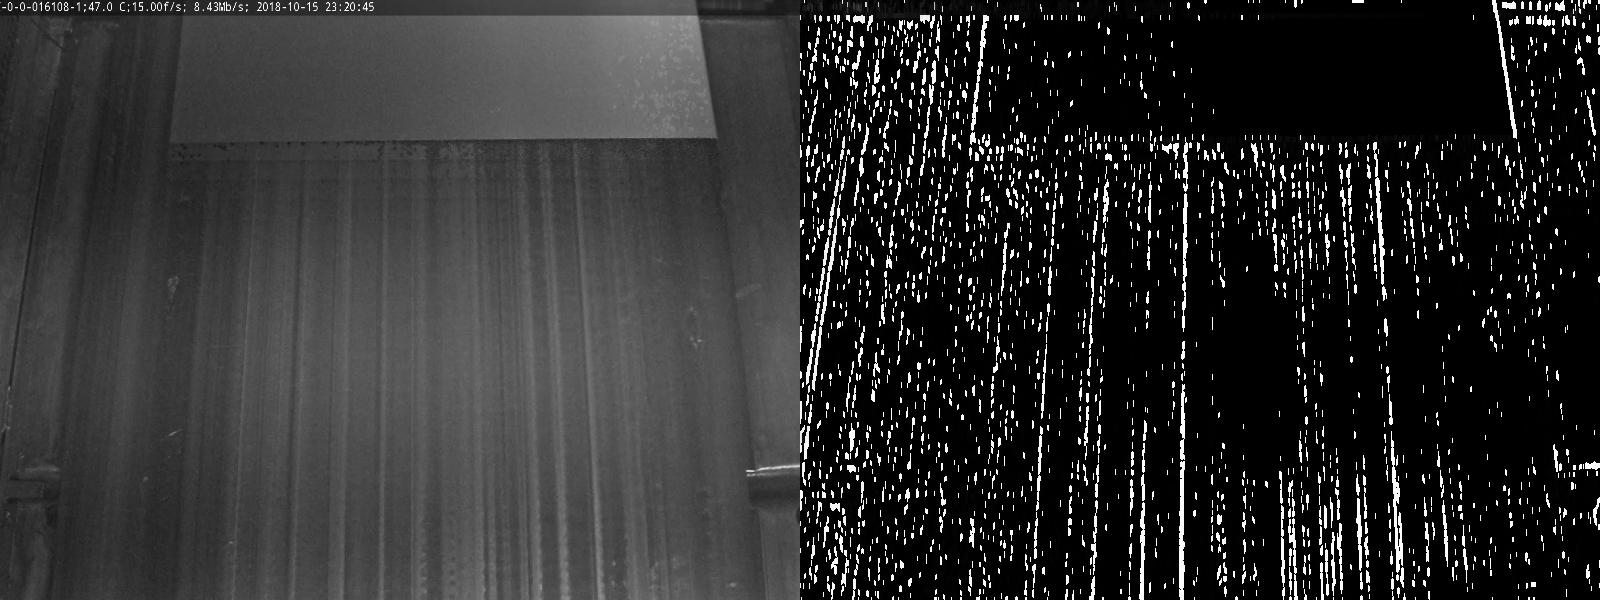

In [141]:
frame_in = frame[:,130:1800, :]
frame_in = cv2.resize(frame_in, (800, 600))
frame_in = cv2.cvtColor(frame_in, cv2.COLOR_BGR2GRAY)
frame_out = cv2.equalizeHist(frame_in)
frame_out = adjust_gamma(frame_out)
frame_out = DoG(frame_out, 1, 1)
se_c = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_c, iterations=1)
se_hl = np.array([[0,0,0],[1,1,1],[0,0,0]], np.ubyte)
se_vl = np.array([[0,1,0],[0,1,0],[0,1,0]], np.ubyte)
frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_vl, iterations=2)
showarray(np.hstack((frame_in,frame_out)))

In [111]:
# input_file_path = r'../hackathon_data/Дефекты кромки1.cva'
# vid = cv2.VideoCapture(input_file_path)

In [143]:
import imutils
import heapq as hq


def get_x_by_y(p, y):
    k = (p[1][1] - p[0][1]) / (p[1][0] - p[0][0])
    b = p[0][1] - k * p[0][0]    
    return int((y-b)/k)
    
# lines = cv2.HoughLines(frame_lines, 0.01, np.pi / 180, 100, None, 0, 0)
# print(len(lines))
def merge_points_to_line(frame_p, scan_line_h, angle_thresh = np.pi*0.4, window = 50): 
    h_p,w_p = frame_p.shape
    h_top = max(0, scan_line_h - window)
    h_bottom = min(h_p, scan_line_h + window)
    frame = frame_p[h_top:h_bottom,...].copy()
    h,w = frame.shape
    pc = np.asarray((w//2,h//2))

    frame = cv2.Canny(frame, 10, 200, None, 3)
    lines = cv2.HoughLinesP(frame, rho=1, theta=np.pi/180, 
                            threshold=30, minLineLength=int(window*0.5), maxLineGap=10)
    lines_left = []
    lines_right = []
    x_left = None
    x_right = None
#     print(len(lines))
    if lines is None:
        return x_left, x_right
    
    for i in range(0, len(lines)):
#         x1,y1,x2,y2 = lines[i][0][0], lines[i][0][1], lines[i][0][2], lines[i][0][3]
#         print(x1,y1,x2,y2)
        p1, p2 = np.asarray([lines[i][0][0], lines[i][0][1]]), np.asarray([lines[i][0][2], lines[i][0][3]])
        angle = math.atan2((p2[1]-p1[1]),(p2[0] - p1[0]))
        
        if (angle < angle_thresh) and (angle > -angle_thresh):
            continue        
#         cv2.line(frame, (p1[0],p1[1]), (p2[0],p2[1]), (255, 255, 255),3) 
           
        d = norm(np.cross(p2-p1, p1-pc))/norm(p2-p1)

        if p1[0] <= pc[0]:
            hq.heappush(lines_left, (d,[p1,p2]))
        else:
            hq.heappush(lines_right,(d,[p1,p2]))  
    
#     print(lines_left)
    if len(lines_left) >0:
        p = hq.nsmallest(1, lines_left)[0][1]  
        x_left = get_x_by_y(p, h//2)
#         cv2.line(frame, (p[0][0],p[0][1]), (p[1][0],p[1][1]), (255, 255, 255),5) 
    if len(lines_right) >0:
        p = hq.nsmallest(1, lines_right)[0][1]
        x_right = get_x_by_y(p, h//2)
#         cv2.line(frame, (p[0][0],p[0][1]), (p[1][0],p[1][1]), (255, 255, 255),5)   
        
    return x_left, x_right #, frame

# for f in [300, 350, 400, 560]:
#     vid.set(cv2.CAP_PROP_POS_FRAMES,f)
#     frame = get_frame(vid)
#     frame = cv2.resize(frame, (600, 400))
#     frame_in = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     frame_out = process(frame)
# #     frame_lines = merge_points_to_line(frame_out)
# #     print(frame_in.shape, frame_out.shape)
# se_vl = np.array([[0,1,0],[0,1,0],[0,1,0]], np.ubyte)
# frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_vl, iterations=5)
# showarray(np.hstack((frame_in, merge_points_to_line(frame_out, 100, window=20))))
# showarray(np.hstack((frame_in, merge_points_to_line(frame_out, 100, window=20))))
x_left, x_right = merge_points_to_line(frame_out, 100)
print(x_left, x_right)
# showarray(img_out)

174 707


In [16]:
# frame_lines = frame_out.copy()
# cdstP = np.copy(frame_lines)

# c_canny = cv2.Canny(cdstP,150,250,apertureSize = 3)

# lines = cv2.HoughLines(c_canny, 1, np.pi / 180, 300, None, 0, 0)
# # print(lines)
# if lines is not None:
#     for i in range(0, len(lines)):
#         rho = lines[i][0][0]
#         theta = lines[i][0][1]
#         a = math.cos(theta)
#         b = math.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
#         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
#         frame_lines = cv2.line(frame_lines, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

# showarray(np.hstack((c_canny,frame_lines)))  

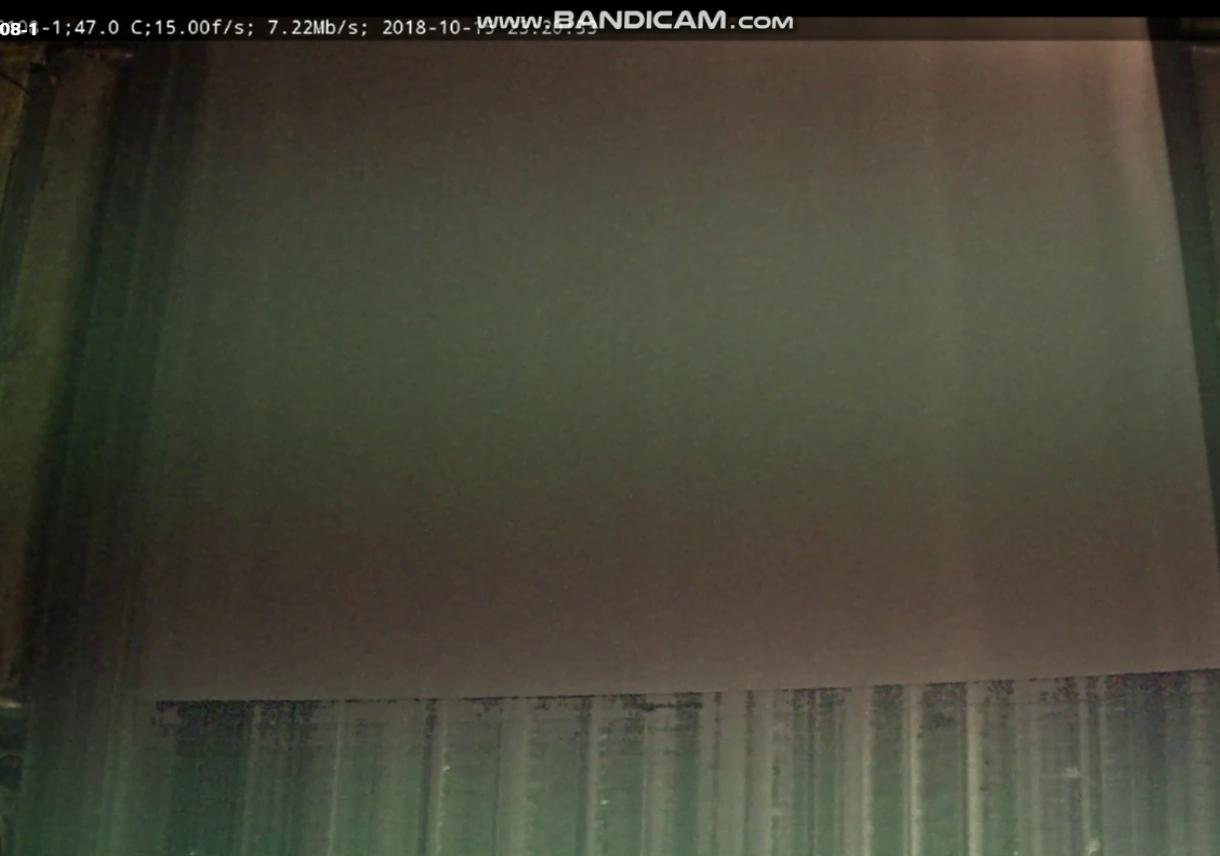

In [441]:
pts_src = np.array([[67, 0], [63, 856], [1552, 856],[1500, 0]])
pts_dst = np.array([[0, 0],[0, 856],[1552, 856],[1552, 0]])

h, status = cv2.findHomography(pts_src, pts_dst)
frame_out = cv2.warpPerspective(frame, h, (frame.shape[1],frame.shape[0]))
showarray(frame_out[:, 130:1350, :])

In [43]:
try:
    while(True):
#         t1 = time.time()
        
        # Capture frame-by-frame
        frame = get_frame(vid)
        frame = frame[:,130:1350, :]        

        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        showarray(merge_points_to_line(process(frame)))
#         t2 = time.time()

#         print('%f FPS' % (1/(t2-t1+1e-07)))
        # Display the frame until new frame is available
        clear_output(wait=True)
except KeyboardInterrupt:
    vid.release()
    print('Stream stopped')

Stream stopped


# TEST